# 0. Load dependencies and data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import *
import warnings
from scipy.optimize import curve_fit
from scipy.stats import vonmises

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


task_colors = {'perception': 'teal', 'wm': 'green', 'ltm': 'orange'}


warnings.filterwarnings('ignore')
wlsubjects = [114, 115, 127, 135, 136, 139, 141, 142]
rois = ["V1", "V2", "V3", "V4", "LO1", "V3ab", "IPS0"]

# Set path to dataframe directory
df_dir = "../../data/dataframes/"

fname = os.path.join(df_dir, 'sub-all_saccades.tsv')
Saccades = pd.read_csv(fname, sep = '\t', index_col = 0)
tasks = ['perception', 'wm', 'ltm']




# 1. Figure 6a
- Plot saccade responses aligned to the target for each condition
- Subject 139 was excluded from this (and all other) saccade analyses due to the EyeTracker not working properly during the scan sessions for that subject.

ltm 		 20.61
perception 	 10.34
wm 		 16.04


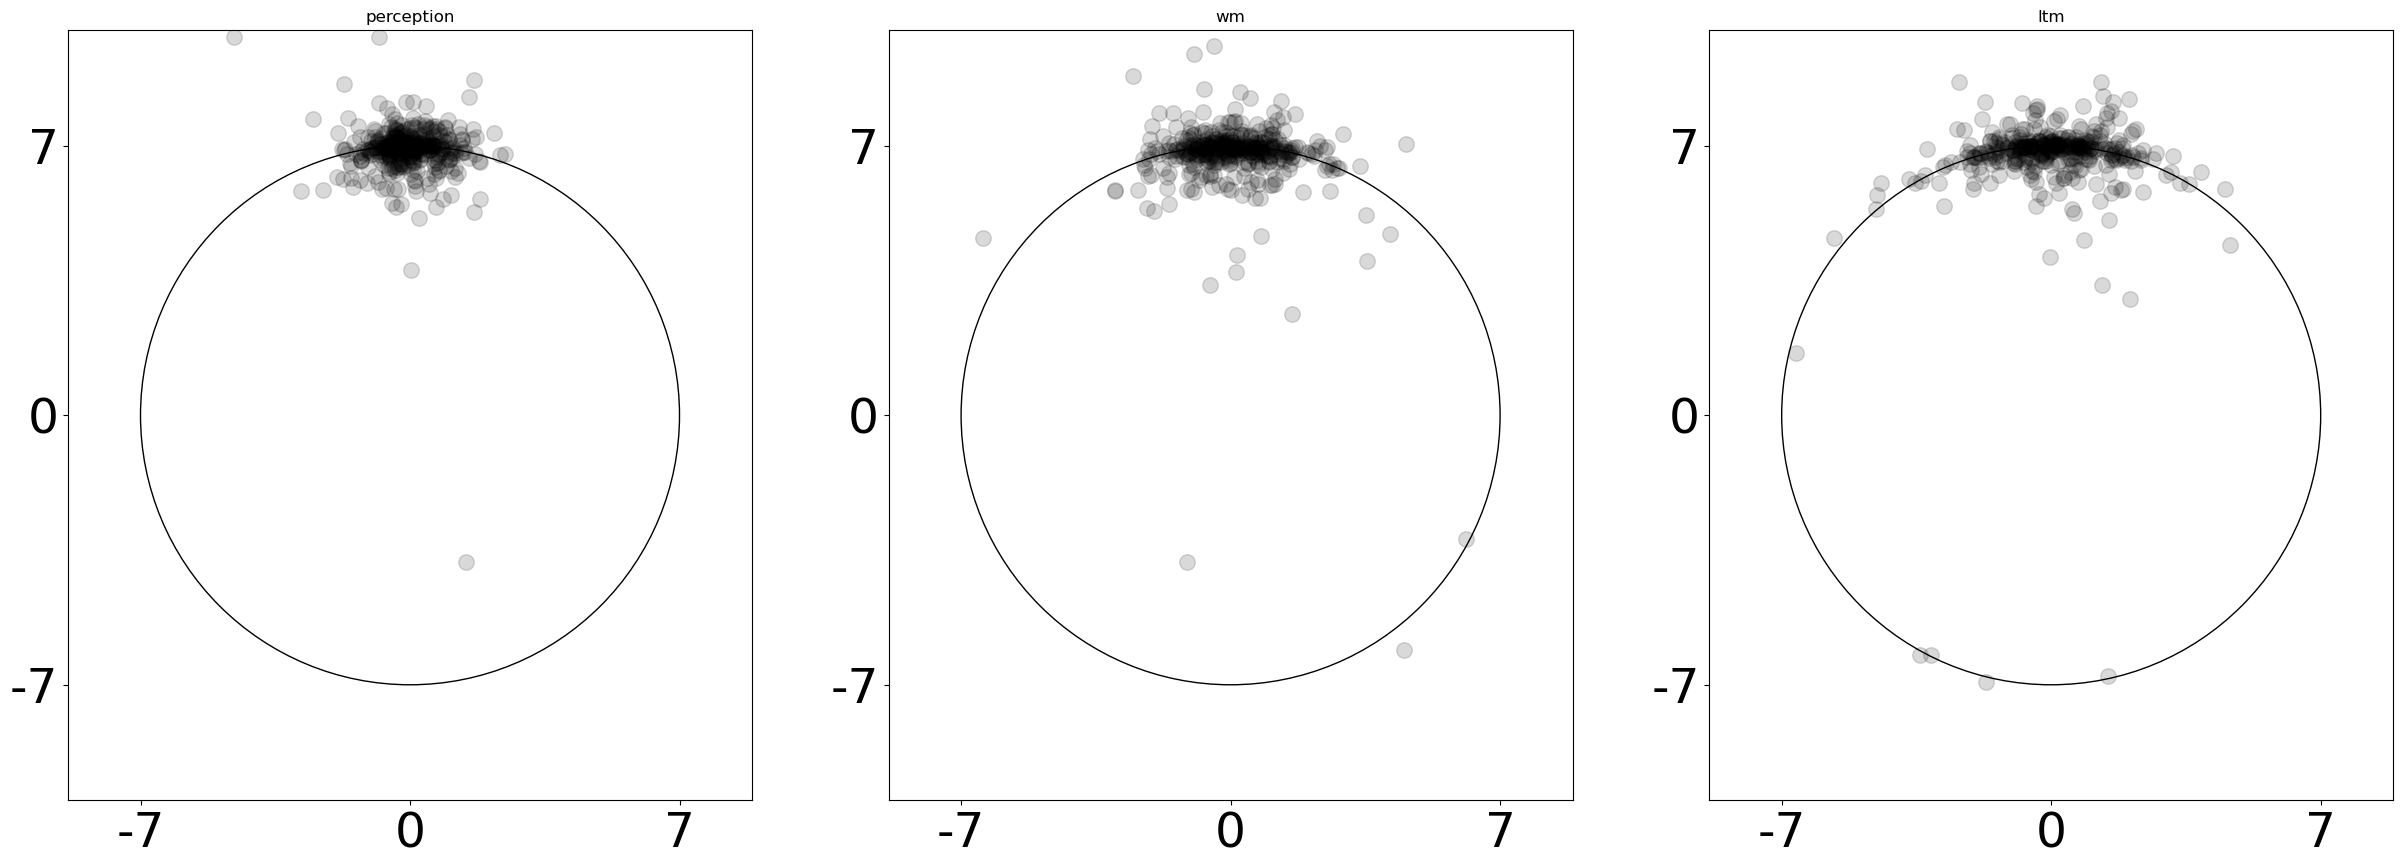

In [8]:
query_str = "task == @task & sacc_label == 'response' & wlsubj != 139 & sac_ecc <= 12"

fig,axs = plt.subplots(1, 3, figsize = [30, 10])
colors = {
    'perception':'teal',
    'ltm':'orange',
    'wm':'green'
}

sz = 35

target_ring = Circle((0, 0), radius = 7, fill = False)

for i, g in enumerate(Saccades.groupby('task', as_index=False)):
    task, s = g
    s = s.query(query_str)
    i = tasks.index(task)
    axs[i].scatter(s.x_centered, s.y_centered, c = 'black', alpha = 0.15, s = 125)

    target_ring = Circle((0, 0), radius = 7, fill = False)
    axs[i].set_yticklabels([-7, 0, 7], size = sz)
    axs[i].set_yticks([-7, 0, 7], size = sz)
    axs[i].set_xticklabels([-7, 0, 7], size = sz)
    axs[i].set_xticks([-7, 0, 7], size = sz)
    axs[i].add_patch(target_ring)

    axs[i].axis('equal')
    axs[i].set_xlim([-10, 10])
    axs[i].set_ylim([-10, 10])

    axs[i].set_title(task)

    if task == 'perception':
        print(task, '\t %0.02f' % np.std(s.ang_dist))
    else:
        print(task, '\t\t %0.02f' % np.std(s.ang_dist))




# 2. Figure 6b
- Load saccade data that has already been split into tertile groups (center, counterclockwise, and clockwise)
- Exclude saccade responses that fell more than 56° from target. This number equals two standard deviations of the angular spread during the long-term memory condition. These trials were only excluded for plotting purposes. They were included in subsequent analyses.
- Plot angular error histogram for each condition and tertile group.
- Plot a density function over the histograms for just the counterclockwise and clockwise groups. 

In [9]:
event_id = Saccades.trial_id + (Saccades.run-1)*16
Saccades['event_id'] = event_id
Saccades_filt = Saccades.query("sacc_label == 'response'")
Saccades_filt['subj'] = Saccades_filt['wlsubj']

t_fname = os.path.join(df_dir, "interstellar_trialwise_saccades.tsv")

T = pd.read_csv(t_fname, sep = '\t', index_col = 0)

T = pd.merge(Saccades_filt, T, on = ['subj', 'event_id'], suffixes=('', '_T'))



('perception', 'clock')
('perception', 'counter')
('perception', 'center')
('wm', 'clock')
('wm', 'counter')
('wm', 'center')
('ltm', 'clock')
('ltm', 'counter')
('ltm', 'center')


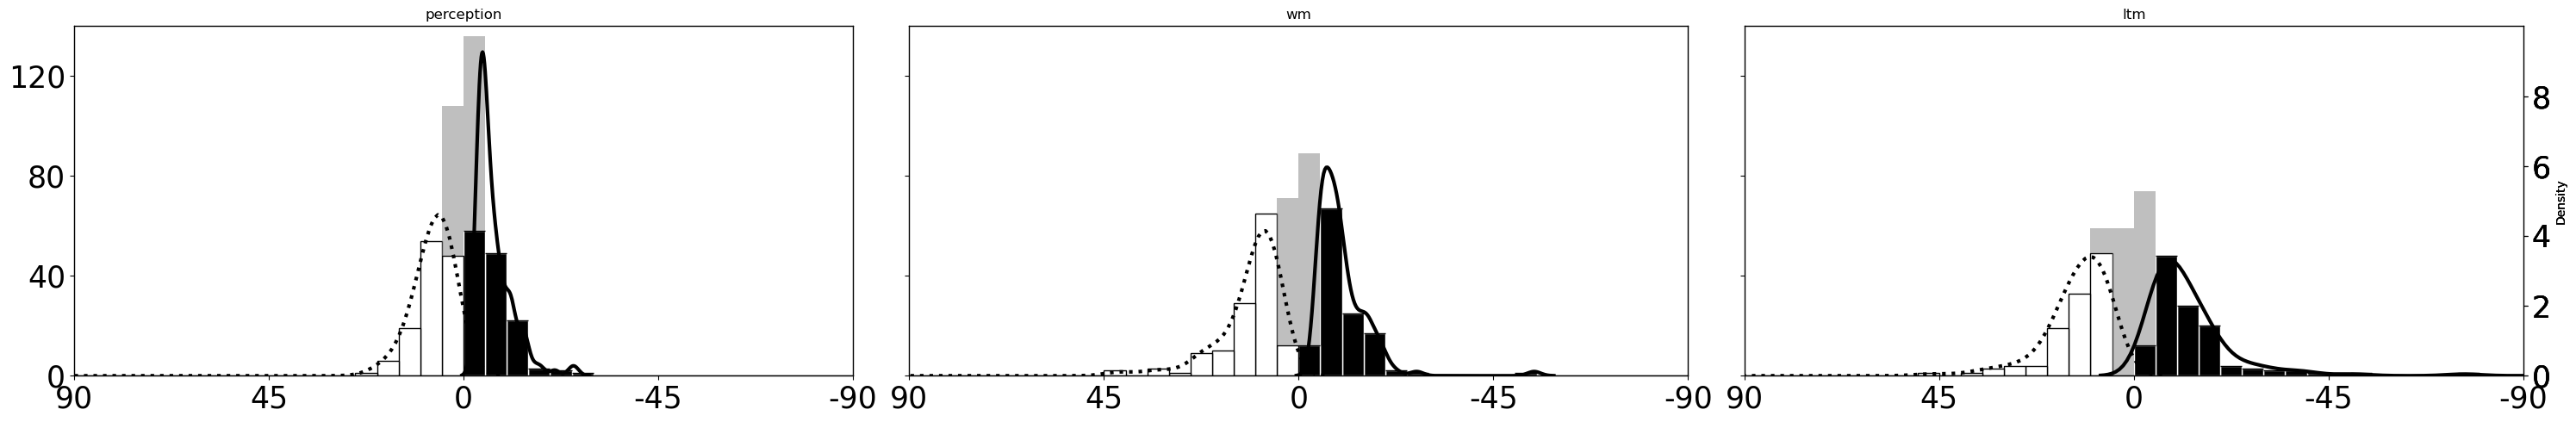

In [10]:
bwm = 0.25

fig, axs = plt.subplots(1, 3, figsize = [30, 5], sharey=True)
# Filtering here for saccade errors less than 2 sds from target, for visualization purposes only.
query = "subj != 139 & task == @task & tertile == @key & sac_ecc <= 12"
bottom = []
for i, g in enumerate(itertools.product(tasks, ['clock', 'counter', 'center'])):
    task, key = g
    print(g)

    s = T.query(query)

    if key =='counter':
        s=s.query("ang_dist < 0")
    elif key == 'clock':
        s=s.query("ang_dist > 0")

    angdist = -s.ang_dist

    i = tasks.index(task)
    ax2 = axs[i].twinx()  
    ax1 = axs[i]


    k, l, sc = vonmises.fit(np.radians(angdist), fscale=1)
    vm = vonmises.pdf(np.linspace(-np.pi, np.pi, 360), loc=l, kappa=k, scale=sc)
    fwhm, _, _, _ = sp.peak_widths(
            vm, np.where(vm == vm.max())[0])

    match key:
        case "counter": 
            ls = ":"
            B = ax1.hist(np.radians(angdist), bins = np.arange(-np.pi, np.pi, np.radians(5)),
                    alpha = 1, color = 'white', edgecolor = 'black', bottom = bottom) 
            sns.kdeplot(np.radians(angdist), ax = ax2, color = 'black', linewidth = 3, linestyle = ls, bw_method = bwm)        
            bottom += B[0]
            
        case "clock": 
            ls = "-"
            B = ax1.hist(np.radians(angdist), bins = np.arange(-np.pi, np.pi, np.radians(5)),
                    alpha = 1, color = 'black', edgecolor = 'white')
            sns.kdeplot(np.radians(angdist), ax = ax2, color = 'black', linewidth = 3, linestyle = ls, bw_method = bwm) 
            bottom = B[0]
        case "center": 
            ls = "-"
            ax1.hist(np.radians(angdist), bins = np.arange(-np.pi, np.pi, np.radians(5)),
                    alpha = 0.5, color = 'gray', bottom = bottom)

    ax2.set_xlim([-np.radians(90), np.radians(90)])
    ax2.set_ylim([0, 10])
    ax1.set_ylim([0, 140])
    ax1.set_title(task)

    xlocs = np.asarray([-np.pi/2, -np.pi/4, 0 , np.pi/4, np.pi/2])
    xlabels = np.degrees(xlocs).astype(int)
    ax1.set_xticks(xlocs)
    ax1.set_xticklabels(xlabels, size = 25)
    ax1.set_yticks(np.arange(0, 121, 40))
    ax1.set_yticklabels(np.arange(0, 121, 40), size = 25)
    if i == 2:
        ax2.set_yticks([0, 2, 4, 6, 8])
        ax2.set_yticklabels([0, 2, 4, 6, 8], size = 25)
        ax2.set_ylabel("Density")
    else:
        ax2.set_yticks([])
        ax2.set_ylabel("")

    ax1.invert_xaxis()
   
fig.tight_layout()

# plt.savefig('images/fig6b.pdf', transparent = True)



# 3. Figure 6c
- Load the cortical tuning analyses by tertile group fits
- Load the cortical tuning analyses by group bootstrapped fits
- Plot the peak location estimates and their 68% confidence intervals for each condition, map, and saccade group (counterclockwise, clockwise)

In [ ]:
p_fname = "interstellar_tertile-sacc_params.tsv"
p_fname = os.path.join(df_dir, p_fname)
b_fname = "interstellar_tertile-sacc_boot_params.tsv"
b_fname = os.path.join(df_dir, b_fname)

P = pd.read_csv(p_fname, sep = '\t', index_col = 0)
B = pd.read_csv(b_fname, sep = '\t', index_col = 0)

P_all = P.groupby(['task', 'tertile']).mean()
B_all = B.groupby(['task', 'tertile', 'n_boot']).mean()

In [55]:
p_cw_fname = "interstellar_tertile-all_clock_params_04-05-2024.tsv"
p_cw_fname = os.path.join(df_dir, p_cw_fname)
p_ccw_fname = "interstellar_tertile-all_counter_params_04-05-2024.tsv"
p_ccw_fname = os.path.join(df_dir, p_ccw_fname)
b_cw_fname = "interstellar_tertile-all_clock_boot_params_04-05-2024.tsv"
b_cw_fname = os.path.join(df_dir, b_cw_fname)
b_ccw_fname = "interstellar_tertile-all_counter_boot_params_04-05-2024.tsv"
b_ccw_fname = os.path.join(df_dir, b_ccw_fname)

P_cw = pd.read_csv(p_cw_fname, sep = '\t', index_col = 0)
P_ccw = pd.read_csv(p_ccw_fname, sep = '\t', index_col = 0)
B_cw = pd.read_csv(b_cw_fname, sep = '\t', index_col = 0)
B_ccw = pd.read_csv(b_ccw_fname, sep = '\t', index_col = 0)


# B_all = B.groupby(['task', 'tertile', 'n_boot']).mean()
B_cw['tertile'] = 'clock'
B_ccw['tertile'] = 'counter'
P_cw['tertile'] = 'clock'
P_ccw['tertile'] = 'counter'

B = pd.concat([B_cw, B_ccw])
P = pd.concat([P_cw, P_ccw])



In [56]:
B_all = B.groupby(['task', 'tertile', 'n_boot']).mean()
P_all = P.groupby(['task', 'tertile']).mean()

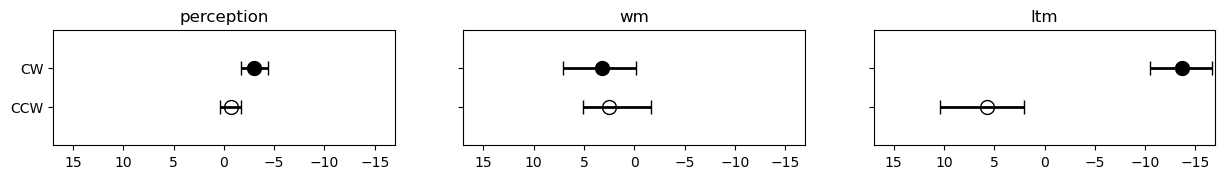

In [58]:
fig, axes = plt.subplots(1, 3, figsize = (15, 1.5), sharey = True)

group = 'tertile'
keys = ['counter', 'clock']
tasks = ['perception', 'wm', 'ltm']

for task, key in itertools.product(tasks, keys):
    ax = axes[tasks.index(task)]
    offset = keys.index(key) * .2
    data = P_all.query("%s==@key & task == @task" % group)
    x = np.degrees(data['loc'])
    y = offset

    ax.set_ylim([-.2, .4])
    ax.set_xlim([-17, 17])

    boot_metric = B_all.query('task == "%s" & %s == @key' % (task, group))['loc'].values
    err_bands1 = np.degrees(np.nanpercentile(boot_metric, [16, 84]))

    lower1, upper1 = err_bands1[0], err_bands1[1]

    match key:
        case "counter": 
            m = "o"
            ls = "--"
            ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 2, c = 'black',  markerfacecolor = 'none', fmt = 'o', alpha = 1,
                marker = m, ms = 10, capsize = 5,)

        case "clock": 
            m = "o"
            ls = "-"
            ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 2, c = 'black', fmt = 'o', alpha = 1,
                marker = m, ms = 10, capsize = 5)
            
    ax.set_yticks([0, 0.2])
    ax.set_yticklabels(['CCW', 'CW'])
    ax.set_title(task)
    ax.invert_xaxis()

save_dir = "images"
plt.savefig(os.path.join(save_dir, "fig6c.pdf") , transparent = True)
    


# 3. Figure 6d
- Load the cortical tuning analyses by tertile group fits
- Load the cortical tuning analyses by group bootstrapped fits
- Plot the peak location estimates and their 68% confidence intervals for each condition, map, and saccade group (counterclockwise, clockwise)

In [50]:

roi_labels = ['V1', 'V2', 'V3', 'V4', 'V3ab', 'IPS0', 'LO1']
P["roi_labels"] = [roi_labels[int(roi-1)] for roi in P.roi]
B["roi_labels"] = [roi_labels[int(roi-1)] for roi in B.roi]

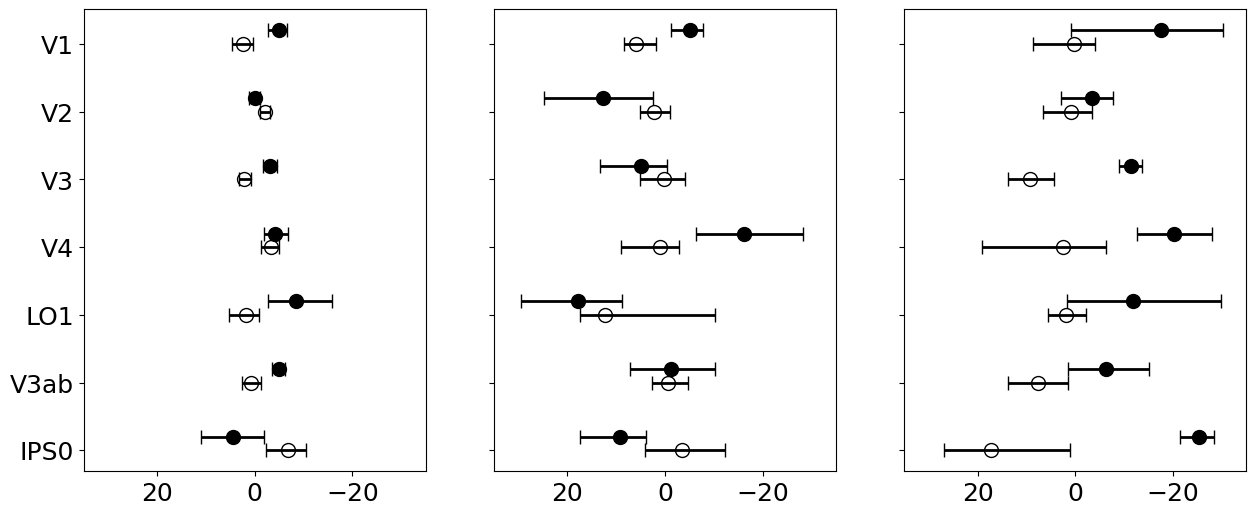

In [54]:
group = 'tertile'
keys = ['counter', 'clock']
tasks = ['perception', 'wm', 'ltm']

fig, axes = plt.subplots(1, 3, figsize = (15, 6), sharey = True)

metrics = ['loc']
lims = {
    'loc': [-30, 30],
    'amp': [0, 2],
    'fwhm': [30, 200]
}
alt_colors = {
    'perception': 'paleturquoise',
    'wm': 'lightgreen',
    'ltm': 'gold'
}
xticklocs = {
    'loc': [-30, 30],
    'amp': [0, 2],
    'fwhm': [30, 200]   
}

tasks = ['perception', 'wm', 'ltm']

boot_metrics = {
    'loc':[],
    'amp':[],
    'fwhm':[]
}

keys = ['counter', 'clock']


for task, metric, key in itertools.product(tasks, metrics, keys):
    ax = axes[tasks.index(task)]
    offset = keys.index(key) * .2
    data = P.query("%s==@key & task == @task" % group)
    x = data[metric]
    if metric == 'loc': x = np.degrees(x)
    # Below reorders y axis rois to be in approx. hierarchical order
    y = [rois.index(label)+1 - offset for label in data.roi_labels]


    # Boot fits
    bfits = []
    for roi in data.roi:
        boot_metric = B.query('task == "%s" & roi == %0.01f & %s == @key' % (task, roi, group))[metric]
        bfits.append(boot_metric)
    bfits=np.vstack(bfits)
    err_bands1 = np.nanpercentile(bfits, [16, 84], axis=1)

    if metric == 'loc': 
        err_bands1 = np.degrees(err_bands1)

    lower1, upper1 = err_bands1[0, :], err_bands1[1, :]

    match key:
        case "counter": 
            m = "o"
            ls = "--"
            ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 2, c = 'black',  markerfacecolor = 'none', fmt = 'o', alpha = 1,
                marker = m, ms = 10, capsize = 5,)

        case "clock": 
            m = "o"
            ls = "-"
            ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 2, c = 'black', fmt = 'o', alpha = 1,
                marker = m, ms = 10, capsize = 5)

    if key == keys[0]: ax.invert_yaxis()
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
    ax.set_yticklabels(rois)

    match task:
        case 'perception': ax.set_xlim([-35, 35])
        case 'wm': ax.set_xlim([-35, 35])
        case 'ltm': ax.set_xlim([-35, 35])

    ax.invert_xaxis()
    
    ax.tick_params(axis='both', which='major', labelsize=18)

    ax.tick_params(axis='both', which='minor', labelsize=0)

save_dir = "images"
plt.savefig(os.path.join(save_dir, "fig6d.pdf") , transparent = True)
    